# RTMDet-Tiny Custom Dataset Evaluation

This notebook provides a comprehensive framework for evaluating RTMDet-tiny on your custom dataset. RTMDet-tiny is optimized for real-time inference while maintaining good accuracy (41.1% AP on COCO with ~1ms latency).

## Project Structure
```
development/
├── rtmdet_tiny_evaluation.ipynb  # This notebook
├── data/                        # Your custom dataset (to be added)
├── outputs/                     # Evaluation results and visualizations
└── configs/                     # Custom configuration files
```

## Key Features of RTMDet-tiny:
- **Speed**: ~1ms inference time on RTX3090
- **Accuracy**: 41.1% mAP on COCO dataset
- **Parameters**: 4.8M parameters
- **FLOPs**: 8.1G
- **Memory Efficient**: Suitable for edge deployment

## 1. Setup Development Environment

First, let's create the necessary directories and set up our development environment.

In [1]:
import os
import sys
from pathlib import Path

# Set up project directories
project_root = Path(os.getcwd())
data_dir = project_root / "data"
outputs_dir = project_root / "outputs"
configs_dir = project_root / "configs"

# Create directories if they don't exist
for directory in [data_dir, outputs_dir, configs_dir]:
    directory.mkdir(exist_ok=True)
    print(f"Created/Verified directory: {directory}")

# Add parent directory to path for MMDetection imports
mmdet_root = project_root.parent
sys.path.insert(0, str(mmdet_root))

print(f"\nProject root: {project_root}")
print(f"MMDetection root: {mmdet_root}")
print("Development environment setup complete!")

# Verify we're in the development folder
print(f"\nCurrent working directory: {os.getcwd()}")
print(f"Available directories: {[d.name for d in project_root.iterdir() if d.is_dir()]}")

Created/Verified directory: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/data
Created/Verified directory: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/outputs
Created/Verified directory: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/configs

Project root: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development
MMDetection root: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection
Development environment setup complete!

Current working directory: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development
Available directories: ['configs', 'data', 'outputs']


## 2. Install Required Dependencies

Check and verify MMDetection installation and dependencies.

In [4]:
# Fix MMCV version compatibility issue
import subprocess
import sys

def fix_mmcv_version():
    """Fix MMCV version compatibility for RTMDet"""
    try:
        import mmcv
        mmcv_version = mmcv.__version__
        print(f"Current MMCV version: {mmcv_version}")
        
        # Check if version is compatible
        if mmcv_version == "2.2.0":
            print("❌ MMCV 2.2.0 detected - incompatible with RTMDet")
            print("📦 Installing compatible MMCV version...")
            
            # Uninstall current version and install compatible version
            commands = [
                [sys.executable, "-m", "pip", "uninstall", "mmcv", "-y"],
                [sys.executable, "-m", "pip", "install", "mmcv==2.1.0", "-f", "https://download.openmmlab.com/mmcv/dist/cu121/torch2.1/index.html"]
            ]
            
            for cmd in commands:
                try:
                    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
                    print(f"✅ Command successful: {' '.join(cmd)}")
                except subprocess.CalledProcessError as e:
                    print(f"⚠️ Command failed: {' '.join(cmd)}")
                    print(f"Error: {e.stderr}")
            
            print("🔄 Please restart the kernel after this installation completes.")
            return False
        else:
            print(f"✅ MMCV version {mmcv_version} is compatible")
            return True
            
    except ImportError:
        print("❌ MMCV not found, installing compatible version...")
        cmd = [sys.executable, "-m", "pip", "install", "mmcv==2.1.0", "-f", "https://download.openmmlab.com/mmcv/dist/cu121/torch2.1/index.html"]
        try:
            subprocess.run(cmd, check=True)
            print("✅ MMCV 2.1.0 installed successfully")
            print("🔄 Please restart the kernel after this installation completes.")
            return False
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to install MMCV: {e}")
            return False

# Run the fix
mmcv_compatible = fix_mmcv_version()

Current MMCV version: 2.1.0
✅ MMCV version 2.1.0 is compatible


### Alternative: Manual MMCV Fix via Terminal

If the automatic fix above doesn't work, run these commands in your terminal:

```bash
# Activate your environment
source ~/.venvs/mmdet311/bin/activate

# Uninstall incompatible MMCV
pip uninstall mmcv -y

# Install compatible version
pip install mmcv==2.1.0 -f https://download.openmmlab.com/mmcv/dist/cu121/torch2.1/index.html

# Verify installation
python -c "import mmcv; print(f'MMCV version: {mmcv.__version__}')"
```

After running these commands, restart the kernel and continue with the notebook.

In [2]:
# Check system information and dependencies
import torch
import numpy as np

print("=== System Information ===")
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")

print(f"NumPy: {np.__version__}")

# Check MMDetection components with version compatibility
try:
    import mmcv
    import mmdet
    import mmengine
    
    print(f"\n=== MMDetection Stack ===")
    print(f"MMCV: {mmcv.__version__}")
    print(f"MMDetection: {mmdet.__version__}")
    print(f"MMEngine: {mmengine.__version__}")
    
    # Check MMCV version compatibility
    mmcv_version = mmcv.__version__
    if mmcv_version == "2.2.0":
        print("⚠️ MMCV 2.2.0 detected - this may cause compatibility issues")
        print("📝 Run the MMCV fix cell above if you encounter errors")
    elif mmcv_version.startswith("2.1") or mmcv_version.startswith("2.0"):
        print("✅ MMCV version is compatible with RTMDet")
    else:
        print(f"⚠️ MMCV version {mmcv_version} compatibility unknown")
    
    print("✅ All MMDetection components are available!")
    
except ImportError as e:
    print(f"❌ MMDetection import error: {e}")
    print("Please ensure MMDetection is properly installed.")
except Exception as e:
    print(f"⚠️ Version compatibility issue: {e}")
    print("This is likely the MMCV 2.2.0 compatibility issue")
    print("📝 Run the MMCV fix cell above to resolve this")

=== System Information ===
Python: 3.11.13 (main, Jun  4 2025, 08:57:30) [GCC 13.3.0]
PyTorch: 2.1.2+cu121
CUDA available: True
CUDA version: 12.1
Current device: 0
Device name: NVIDIA GeForce RTX 4090
NumPy: 1.26.4

=== MMDetection Stack ===
MMCV: 2.1.0
MMDetection: 3.3.0
MMEngine: 0.10.7
✅ MMCV version is compatible with RTMDet
✅ All MMDetection components are available!


## 3. Import Libraries and Modules

Import all necessary libraries for RTMDet-tiny evaluation.

In [3]:
# Core libraries
import time
import json
import glob
from collections import defaultdict

# Scientific computing
import numpy as np
import pandas as pd

# Computer vision and image processing
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# MMDetection imports
from mmdet.apis import DetInferencer, init_detector, inference_detector
from mmdet.registry import VISUALIZERS
from mmengine import Config
from mmengine.structures import InstanceData

# Evaluation utilities
from mmdet.evaluation import CocoMetric
from mmengine.evaluator import Evaluator

# Visualization
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

✅ All libraries imported successfully!
Using device: cuda


## 4. Configure RTMDet-tiny Model

Load and configure the RTMDet-tiny model configuration.

In [4]:
# RTMDet-tiny configuration
config_file = str(mmdet_root / 'configs' / 'rtmdet' / 'rtmdet_tiny_8xb32-300e_coco.py')
checkpoint_url = 'https://download.openmmlab.com/mmdetection/v3.0/rtmdet/rtmdet_tiny_8xb32-300e_coco/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'

print("=== RTMDet-tiny Configuration ===")
print(f"Config file: {config_file}")
print(f"Checkpoint URL: {checkpoint_url}")

# Load configuration
try:
    cfg = Config.fromfile(config_file)
    print("✅ Configuration loaded successfully!")
    
    # Print key model parameters
    print(f"\nModel type: {cfg.model.type}")
    print(f"Backbone: {cfg.model.backbone.type}")
    print(f"Neck: {cfg.model.neck.type}")
    print(f"Head: {cfg.model.bbox_head.type}")
    
    # Input size
    if hasattr(cfg, 'test_pipeline'):
        for transform in cfg.test_pipeline:
            if transform['type'] == 'Resize':
                print(f"Input size: {transform.get('scale', 'Not specified')}")
                break
    
except Exception as e:
    print(f"❌ Error loading configuration: {e}")

# Model specifications
rtmdet_tiny_specs = {
    'parameters': '4.8M',
    'flops': '8.1G',
    'coco_ap': 41.1,
    'latency_rtx3090': '0.98ms',
    'latency_t4': '2.34ms'
}

print(f"\n=== RTMDet-tiny Specifications ===")
for key, value in rtmdet_tiny_specs.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

=== RTMDet-tiny Configuration ===
Config file: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py
Checkpoint URL: https://download.openmmlab.com/mmdetection/v3.0/rtmdet/rtmdet_tiny_8xb32-300e_coco/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
✅ Configuration loaded successfully!

Model type: RTMDet
Backbone: CSPNeXt
Neck: CSPNeXtPAFPN
Head: RTMDetSepBNHead
Input size: (640, 640)

=== RTMDet-tiny Specifications ===
Parameters: 4.8M
Flops: 8.1G
Coco Ap: 41.1
Latency Rtx3090: 0.98ms
Latency T4: 2.34ms


## 5. Load Pre-trained Weights

Initialize the RTMDet-tiny model with pre-trained weights.

In [10]:
# Configure and load RTMDet-tiny model for package detection
print("=== RTMDet-tiny Model Configuration ===")

# Model specification
config_file = 'configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py'
checkpoint_url = 'https://download.openmmlab.com/mmdetection/v3.0/rtmdet/rtmdet_tiny_8xb32-300e_coco/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'

# Check if config exists
config_path = mmdet_root / config_file
if not config_path.exists():
    print(f"❌ Config file not found: {config_path}")
    inferencer = None
else:
    print(f"✅ Config found: {config_path}")
    
    try:
        print("🔄 Loading RTMDet-tiny model...")
        print(f"Config: {config_file}")
        print(f"Checkpoint: {checkpoint_url}")
        print(f"Device: {device}")
        
        # Initialize DetInferencer with basic parameters
        inferencer = DetInferencer(
            model=str(config_path),
            weights=checkpoint_url,
            device=device
        )
        
        # Configure inference parameters for better package detection
        # These will be applied during inference calls
        inference_config = {
            'score_thr': 0.3,      # Confidence threshold (increased from default ~0.1)
            'nms_thr': 0.5,        # NMS IoU threshold  
            'max_per_img': 50,     # Maximum detections per image (reduced from 300)
        }
        
        # Store config for later use during inference
        inferencer.custom_config = inference_config
        
        print("✅ RTMDet-tiny model loaded successfully!")
        
        # Display model info
        print(f"\n=== Model Information ===")
        for key, value in rtmdet_tiny_specs.items():
            print(f"{key}: {value}")
            
        print(f"\n=== Custom Inference Configuration ===")
        print("These settings will be applied during inference to reduce false positives:")
        for key, value in inference_config.items():
            print(f"{key}: {value}")
        
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        inferencer = None

=== RTMDet-tiny Model Configuration ===
✅ Config found: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py
🔄 Loading RTMDet-tiny model...
Config: configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py
Checkpoint: https://download.openmmlab.com/mmdetection/v3.0/rtmdet/rtmdet_tiny_8xb32-300e_coco/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
Device: cuda
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v3.0/rtmdet/rtmdet_tiny_8xb32-300e_coco/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

✅ RTMDet-tiny model loaded successfully!

=== Model Information ===
parameters: 4.8M
flops: 8.1G
coco_ap: 41.1
latency_rtx3090: 0.98ms
latency_t4: 2.34ms

=== Custom Inference Configuration ===
These settings will be applied during inference to reduce false pos

## 6. Prepare Dataset Loading Functions

Create functions to handle your custom dataset. These are template functions that you can modify based on your dataset format.

In [6]:
class YOLOKeypointDatasetLoader:
    """
    Loader for YOLO keypoint format dataset with package detection and 8 corner keypoints.
    Format: class_id x_center y_center width height x1 y1 vis1 x2 y2 vis2 ... x8 y8 vis8
    """
    
    def __init__(self, dataset_root):
        self.dataset_root = Path(dataset_root)
        self.class_names = ['package']  # Single class from data.yaml
        self.num_keypoints = 8
        self.dataset_splits = {}
        
    def parse_yolo_keypoint_line(self, line, img_width, img_height):
        """Parse a single line from YOLO keypoint format"""
        parts = line.strip().split()
        if len(parts) < 5 + (self.num_keypoints * 3):
            return None
            
        class_id = int(parts[0])
        x_center = float(parts[1]) * img_width
        y_center = float(parts[2]) * img_height
        width = float(parts[3]) * img_width
        height = float(parts[4]) * img_height
        
        # Convert center format to corner format for AABB
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        
        # Parse keypoints
        keypoints = []
        for i in range(self.num_keypoints):
            idx_start = 5 + i * 3
            kpt_x = float(parts[idx_start]) * img_width
            kpt_y = float(parts[idx_start + 1]) * img_height
            visibility = int(parts[idx_start + 2])  # 2=visible, 1=occluded, 0=not labeled
            keypoints.append([kpt_x, kpt_y, visibility])
        
        return {
            'class_id': class_id,
            'class_name': self.class_names[class_id],
            'bbox': [x1, y1, x2, y2],  # AABB format
            'center': [x_center, y_center],
            'size': [width, height],
            'keypoints': keypoints,
            'num_visible_keypoints': sum(1 for kpt in keypoints if kpt[2] == 2),
            'num_occluded_keypoints': sum(1 for kpt in keypoints if kpt[2] == 1)
        }
    
    def load_split(self, split='train', max_images=None):
        """Load a specific split of the dataset (train/val/test)"""
        split_dir = self.dataset_root / split
        images_dir = split_dir / 'images'
        labels_dir = split_dir / 'labels'
        
        if not images_dir.exists() or not labels_dir.exists():
            print(f"❌ Split directory not found: {split_dir}")
            return []
        
        # Get all image files
        image_files = list(images_dir.glob('*.png')) + list(images_dir.glob('*.jpg'))
        if max_images:
            image_files = image_files[:max_images]
        
        dataset = []
        total_annotations = 0
        
        print(f"Loading {split} split...")
        for img_file in image_files:
            label_file = labels_dir / (img_file.stem + '.txt')
            
            if not label_file.exists():
                continue
                
            # Get image dimensions
            try:
                img = cv2.imread(str(img_file))
                if img is None:
                    continue
                img_height, img_width = img.shape[:2]
            except Exception:
                continue
            
            # Parse annotations
            annotations = []
            try:
                with open(label_file, 'r') as f:
                    for line in f:
                        annotation = self.parse_yolo_keypoint_line(line, img_width, img_height)
                        if annotation:
                            annotations.append(annotation)
                            total_annotations += 1
            except Exception as e:
                print(f"Error parsing {label_file}: {e}")
                continue
            
            if annotations:  # Only include images with valid annotations
                dataset.append({
                    'image_path': str(img_file),
                    'label_path': str(label_file),
                    'image_width': img_width,
                    'image_height': img_height,
                    'annotations': annotations,
                    'num_objects': len(annotations)
                })
        
        self.dataset_splits[split] = dataset
        
        print(f"✅ Loaded {split} split:")
        print(f"  - Images: {len(dataset)}")
        print(f"  - Total annotations: {total_annotations}")
        print(f"  - Avg objects per image: {total_annotations/len(dataset):.1f}")
        
        return dataset
    
    def get_statistics(self, split='train'):
        """Get detailed statistics about the dataset"""
        if split not in self.dataset_splits:
            print(f"Split {split} not loaded yet")
            return None
            
        dataset = self.dataset_splits[split]
        
        stats = {
            'total_images': len(dataset),
            'total_objects': sum(item['num_objects'] for item in dataset),
            'avg_objects_per_image': np.mean([item['num_objects'] for item in dataset]),
            'max_objects_per_image': max(item['num_objects'] for item in dataset),
            'min_objects_per_image': min(item['num_objects'] for item in dataset),
            'images_with_multiple_objects': sum(1 for item in dataset if item['num_objects'] > 1),
        }
        
        # Keypoint visibility statistics
        total_keypoints = 0
        visible_keypoints = 0
        occluded_keypoints = 0
        
        for item in dataset:
            for ann in item['annotations']:
                total_keypoints += len(ann['keypoints'])
                visible_keypoints += ann['num_visible_keypoints']
                occluded_keypoints += ann['num_occluded_keypoints']
        
        stats.update({
            'total_keypoints': total_keypoints,
            'visible_keypoints': visible_keypoints,
            'occluded_keypoints': occluded_keypoints,
            'visibility_rate': visible_keypoints / total_keypoints if total_keypoints > 0 else 0,
            'occlusion_rate': occluded_keypoints / total_keypoints if total_keypoints > 0 else 0
        })
        
        return stats

# Load your YOLO keypoint dataset
def prepare_your_dataset():
    """
    Load the YOLO keypoint format dataset with package detection and 8 corner keypoints.
    """
    
    # Your dataset path
    dataset_root = "/media/robun2/T7 Shield/VaultRobotics/OTT_bounding_box_labelled_images/large_dataset"
    
    print("=== Loading YOLO Keypoint Dataset ===")
    print(f"Dataset location: {dataset_root}")
    
    # Initialize the loader
    loader = YOLOKeypointDatasetLoader(dataset_root)
    
    # Load validation split for evaluation (smaller than train for faster testing)
    print("\nLoading validation split for evaluation...")
    val_dataset = loader.load_split('valid', max_images=100)  # Limit to 100 images for initial testing
    
    if not val_dataset:
        print("No validation data found, trying train split...")
        train_dataset = loader.load_split('train', max_images=50)  # Even smaller subset
        val_dataset = train_dataset
    
    # Get dataset statistics
    if val_dataset:
        print(f"\n=== Dataset Statistics ===")
        stats = loader.get_statistics('valid' if 'valid' in loader.dataset_splits else 'train')
        if stats:
            for key, value in stats.items():
                if isinstance(value, float):
                    print(f"{key.replace('_', ' ').title()}: {value:.2f}")
                else:
                    print(f"{key.replace('_', ' ').title()}: {value}")
    
    # Convert to list of image paths for RTMDet evaluation
    image_paths = [item['image_path'] for item in val_dataset]
    
    # Store dataset information globally for later use
    global dataset_info
    dataset_info = {
        'loader': loader,
        'dataset': val_dataset,
        'image_paths': image_paths,
        'stats': stats if val_dataset else None
    }
    
    print(f"\n✅ Dataset prepared: {len(image_paths)} images ready for evaluation")
    
    return image_paths

print("✅ YOLO Keypoint Dataset loader implemented!")
print("📝 Ready to load your package detection dataset with 8 corner keypoints.")

✅ YOLO Keypoint Dataset loader implemented!
📝 Ready to load your package detection dataset with 8 corner keypoints.


## 7. Implement Evaluation Metrics

Set up comprehensive evaluation metrics for assessing RTMDet-tiny performance.

In [7]:
class RTMDetEvaluator:
    """Comprehensive evaluation class for RTMDet-tiny performance assessment"""
    
    def __init__(self, class_names=None):
        self.class_names = class_names or ['package']  # Updated for package detection
        self.results = []
        self.inference_times = []
        
    def calculate_iou(self, box1, box2):
        """Calculate IoU between two bounding boxes"""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        if x2 <= x1 or y2 <= y1:
            return 0.0
        
        intersection = (x2 - x1) * (y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0.0
    
    def evaluate_with_ground_truth(self, predictions_results, dataset_info):
        """
        Evaluate RTMDet predictions against YOLO keypoint ground truth annotations
        """
        if not dataset_info or 'dataset' not in dataset_info:
            print("No ground truth dataset available")
            return None
            
        dataset = dataset_info['dataset']
        
        # Create a mapping from image path to ground truth
        gt_mapping = {}
        for item in dataset:
            gt_mapping[item['image_path']] = item['annotations']
        
        all_precisions = []
        all_recalls = []
        all_f1s = []
        iou_thresholds = [0.3, 0.5, 0.7, 0.9]  # Multiple IoU thresholds
        
        # Results for each IoU threshold
        threshold_results = {}
        
        for iou_thresh in iou_thresholds:
            threshold_results[iou_thresh] = {
                'precisions': [],
                'recalls': [],
                'f1s': [],
                'true_positives': 0,
                'false_positives': 0,
                'false_negatives': 0
            }
        
        total_gt_objects = 0
        total_pred_objects = 0
        matched_images = 0
        
        print(f"Evaluating {len(predictions_results)} predictions against ground truth...")
        
        for pred_result in predictions_results:
            img_path = pred_result['image_path']
            
            # Get ground truth for this image
            if img_path not in gt_mapping:
                continue
                
            matched_images += 1
            gt_annotations = gt_mapping[img_path]
            
            # Extract predicted bboxes (RTMDet format)
            pred_bboxes = pred_result.get('bboxes', [])
            pred_scores = pred_result.get('scores', [])
            
            # Convert ground truth to bbox format for comparison
            gt_bboxes = [ann['bbox'] for ann in gt_annotations]
            
            total_gt_objects += len(gt_bboxes)
            total_pred_objects += len(pred_bboxes)
            
            # Evaluate at each IoU threshold
            for iou_thresh in iou_thresholds:
                precision, recall, f1, tp, fp, fn = self._evaluate_image_at_threshold(
                    pred_bboxes, pred_scores, gt_bboxes, iou_thresh
                )
                
                threshold_results[iou_thresh]['precisions'].append(precision)
                threshold_results[iou_thresh]['recalls'].append(recall)
                threshold_results[iou_thresh]['f1s'].append(f1)
                threshold_results[iou_thresh]['true_positives'] += tp
                threshold_results[iou_thresh]['false_positives'] += fp
                threshold_results[iou_thresh]['false_negatives'] += fn
        
        # Calculate overall metrics
        evaluation_results = {
            'total_images_evaluated': matched_images,
            'total_gt_objects': total_gt_objects,
            'total_pred_objects': total_pred_objects,
            'avg_gt_per_image': total_gt_objects / matched_images if matched_images > 0 else 0,
            'avg_pred_per_image': total_pred_objects / matched_images if matched_images > 0 else 0,
        }
        
        # Calculate metrics for each threshold
        for iou_thresh in iou_thresholds:
            results = threshold_results[iou_thresh]
            
            # Overall precision, recall, F1
            total_tp = results['true_positives']
            total_fp = results['false_positives']
            total_fn = results['false_negatives']
            
            overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
            overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
            overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0
            
            # Average precision, recall, F1 across images
            avg_precision = np.mean(results['precisions']) if results['precisions'] else 0
            avg_recall = np.mean(results['recalls']) if results['recalls'] else 0
            avg_f1 = np.mean(results['f1s']) if results['f1s'] else 0
            
            evaluation_results[f'IoU_{iou_thresh}'] = {
                'overall_precision': overall_precision,
                'overall_recall': overall_recall,
                'overall_f1': overall_f1,
                'avg_precision': avg_precision,
                'avg_recall': avg_recall,
                'avg_f1': avg_f1,
                'true_positives': total_tp,
                'false_positives': total_fp,
                'false_negatives': total_fn
            }
        
        # Calculate mAP across IoU thresholds
        map_scores = []
        for iou_thresh in iou_thresholds:
            map_scores.append(evaluation_results[f'IoU_{iou_thresh}']['avg_precision'])
        evaluation_results['mAP'] = np.mean(map_scores)
        
        return evaluation_results
    
    def _evaluate_image_at_threshold(self, pred_bboxes, pred_scores, gt_bboxes, iou_threshold):
        """Evaluate predictions for a single image at specific IoU threshold"""
        if not pred_bboxes and not gt_bboxes:
            return 1.0, 1.0, 1.0, 0, 0, 0  # Perfect score for empty predictions and ground truth
        if not pred_bboxes:
            return 0.0, 0.0, 0.0, 0, 0, len(gt_bboxes)  # No predictions, all ground truth are false negatives
        if not gt_bboxes:
            return 0.0, 0.0, 0.0, 0, len(pred_bboxes), 0  # No ground truth, all predictions are false positives
        
        # Match predictions to ground truths
        matched_gt = set()
        true_positives = 0
        
        # Sort predictions by confidence score (descending)
        if pred_scores:
            sorted_indices = np.argsort(pred_scores)[::-1]
            sorted_pred_bboxes = [pred_bboxes[i] for i in sorted_indices]
        else:
            sorted_pred_bboxes = pred_bboxes
        
        for pred_bbox in sorted_pred_bboxes:
            best_iou = 0
            best_gt_idx = -1
            
            for i, gt_bbox in enumerate(gt_bboxes):
                if i in matched_gt:
                    continue
                    
                iou = self.calculate_iou(pred_bbox, gt_bbox)
                if iou > best_iou and iou >= iou_threshold:
                    best_iou = iou
                    best_gt_idx = i
            
            if best_gt_idx != -1:
                matched_gt.add(best_gt_idx)
                true_positives += 1
        
        false_positives = len(pred_bboxes) - true_positives
        false_negatives = len(gt_bboxes) - true_positives
        
        precision = true_positives / len(pred_bboxes) if pred_bboxes else 0
        recall = true_positives / len(gt_bboxes) if gt_bboxes else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return precision, recall, f1, true_positives, false_positives, false_negatives
    
    def calculate_precision_recall(self, predictions, ground_truths, iou_threshold=0.5):
        """Calculate precision and recall for given IoU threshold"""
        if not predictions or not ground_truths:
            return 0.0, 0.0, 0.0  # precision, recall, f1
        
        # Match predictions to ground truths
        matched_gt = set()
        true_positives = 0
        
        for pred in predictions:
            best_iou = 0
            best_gt_idx = -1
            
            for i, gt in enumerate(ground_truths):
                if i in matched_gt:
                    continue
                    
                iou = self.calculate_iou(pred['bbox'], gt['bbox'])
                if iou > best_iou and iou >= iou_threshold:
                    best_iou = iou
                    best_gt_idx = i
            
            if best_gt_idx != -1:
                matched_gt.add(best_gt_idx)
                true_positives += 1
        
        precision = true_positives / len(predictions) if predictions else 0
        recall = true_positives / len(ground_truths) if ground_truths else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return precision, recall, f1
    
    def calculate_map(self, all_predictions, all_ground_truths, iou_thresholds=None):
        """Calculate mean Average Precision (mAP)"""
        if iou_thresholds is None:
            iou_thresholds = np.arange(0.5, 1.0, 0.05)  # COCO-style mAP
        
        aps = []
        for threshold in iou_thresholds:
            precisions = []
            for preds, gts in zip(all_predictions, all_ground_truths):
                precision, _, _ = self.calculate_precision_recall(preds, gts, threshold)
                precisions.append(precision)
            
            ap = np.mean(precisions) if precisions else 0
            aps.append(ap)
        
        return np.mean(aps)
    
    def benchmark_speed(self, inferencer, test_images, num_warmup=5, num_runs=20):
        """Benchmark inference speed"""
        if not test_images:
            print("No test images provided for speed benchmarking")
            return {}
        
        print(f"Speed benchmarking with {len(test_images)} images...")
        
        # Warmup
        for i in range(min(num_warmup, len(test_images))):
            _ = inferencer(str(test_images[i]), return_vis=False)
        
        # Benchmark
        times = []
        for i in range(min(num_runs, len(test_images))):
            img_path = str(test_images[i])
            
            start_time = time.time()
            _ = inferencer(img_path, return_vis=False)
            end_time = time.time()
            
            times.append(end_time - start_time)
        
        # Calculate statistics
        times = np.array(times)
        speed_stats = {
            'mean_time': np.mean(times),
            'std_time': np.std(times),
            'min_time': np.min(times),
            'max_time': np.max(times),
            'median_time': np.median(times),
            'fps': 1.0 / np.mean(times),
            'total_images': len(times)
        }
        
        return speed_stats
    
    def generate_report(self, speed_stats=None, accuracy_stats=None):
        """Generate comprehensive evaluation report"""
        report = {
            'model': 'RTMDet-tiny',
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'device': device
        }
        
        if speed_stats:
            report['speed'] = speed_stats
        
        if accuracy_stats:
            report['accuracy'] = accuracy_stats
        
        return report

# Initialize evaluator
evaluator = RTMDetEvaluator()
print("✅ Evaluation metrics implemented!")
print("Available metrics:")
print("- IoU calculation")
print("- Precision, Recall, F1-score")
print("- mean Average Precision (mAP)")
print("- Speed benchmarking")
print("- Comprehensive reporting")

✅ Evaluation metrics implemented!
Available metrics:
- IoU calculation
- Precision, Recall, F1-score
- mean Average Precision (mAP)
- Speed benchmarking
- Comprehensive reporting


## 8. Run Model Inference

Execute RTMDet-tiny inference on your dataset.

In [12]:
# Load your dataset (modify this section when you provide your dataset)
print("=== Dataset Loading ===")
test_images = prepare_your_dataset()

if test_images:
    print(f"Loaded {len(test_images)} images for evaluation")
else:
    print("📝 No dataset found. Using demo image for testing.")
    # Use demo image if no custom dataset is available
    demo_image = mmdet_root / 'demo' / 'demo.jpg'
    if demo_image.exists():
        test_images = [demo_image]
        print(f"Using demo image: {demo_image}")
    else:
        print("❌ No demo image found either.")

def filter_predictions(predictions, score_threshold=0.3, max_per_img=50):
    """
    Filter predictions by confidence score and limit number of detections
    """
    if not predictions or 'bboxes' not in predictions:
        return predictions
    
    bboxes = predictions.get('bboxes', [])
    scores = predictions.get('scores', [])
    labels = predictions.get('labels', [])
    
    if not bboxes or not scores:
        return predictions
    
    # Convert to numpy arrays for easier manipulation
    bboxes = np.array(bboxes)
    scores = np.array(scores)
    labels = np.array(labels) if labels else np.zeros(len(scores))
    
    # Filter by score threshold
    score_mask = scores >= score_threshold
    
    if not np.any(score_mask):
        # No predictions above threshold
        return {
            'bboxes': [],
            'scores': [],
            'labels': []
        }
    
    # Apply score filter
    filtered_bboxes = bboxes[score_mask]
    filtered_scores = scores[score_mask]
    filtered_labels = labels[score_mask]
    
    # Sort by score and limit to max_per_img
    if len(filtered_scores) > max_per_img:
        sorted_indices = np.argsort(filtered_scores)[::-1]  # Sort descending
        top_indices = sorted_indices[:max_per_img]
        
        filtered_bboxes = filtered_bboxes[top_indices]
        filtered_scores = filtered_scores[top_indices]
        filtered_labels = filtered_labels[top_indices]
    
    return {
        'bboxes': filtered_bboxes.tolist(),
        'scores': filtered_scores.tolist(),
        'labels': filtered_labels.tolist()
    }

# Run inference if we have images and a loaded model
if test_images and inferencer is not None:
    print(f"\n=== Running Inference on {len(test_images)} Images ===")
    
    # Get custom configuration
    custom_config = getattr(inferencer, 'custom_config', {})
    score_threshold = custom_config.get('score_thr', 0.3)
    max_per_img = custom_config.get('max_per_img', 50)
    
    print("Using optimized settings to reduce false positives:")
    print(f"- Score threshold: {score_threshold}")
    print(f"- Max detections per image: {max_per_img}")
    
    all_results = []
    inference_times = []
    
    for i, img_path in enumerate(test_images):
        print(f"Processing image {i+1}/{len(test_images)}: {Path(img_path).name}")
        
        # Time the inference
        start_time = time.time()
        result = inferencer(str(img_path), return_vis=False)
        end_time = time.time()
        
        inference_time = end_time - start_time
        inference_times.append(inference_time)
        
        # Extract and filter predictions
        if result and 'predictions' in result:
            raw_predictions = result['predictions'][0]
            
            # Apply custom filtering
            filtered_predictions = filter_predictions(
                raw_predictions, 
                score_threshold=score_threshold,
                max_per_img=max_per_img
            )
            
            # Process filtered results
            bboxes = filtered_predictions.get('bboxes', [])
            scores = filtered_predictions.get('scores', [])
            labels = filtered_predictions.get('labels', [])
            
            # Store results
            img_result = {
                'image_path': str(img_path),
                'inference_time': inference_time,
                'num_detections': len(bboxes),
                'bboxes': bboxes,
                'scores': scores,
                'labels': labels
            }
            all_results.append(img_result)
            
            print(f"  - Detections (filtered): {len(bboxes)}")
            if scores:
                print(f"  - Max confidence: {max(scores):.3f}")
                print(f"  - Min confidence: {min(scores):.3f}")
            print(f"  - Inference time: {inference_time:.3f}s")
    
    # Calculate overall statistics
    if all_results:
        total_detections = sum(r['num_detections'] for r in all_results)
        avg_inference_time = np.mean(inference_times)
        avg_fps = 1.0 / avg_inference_time
        
        print(f"\n=== Inference Summary ===")
        print(f"Total images processed: {len(all_results)}")
        print(f"Total detections: {total_detections}")
        print(f"Average detections per image: {total_detections/len(all_results):.1f}")
        print(f"Average inference time: {avg_inference_time:.3f}s")
        print(f"Average FPS: {avg_fps:.1f}")
        
        # Show confidence distribution
        all_scores = []
        for result in all_results:
            all_scores.extend(result['scores'])
        
        if all_scores:
            print(f"\n=== Confidence Score Distribution (after filtering) ===")
            print(f"Total predictions: {len(all_scores)}")
            print(f"Mean confidence: {np.mean(all_scores):.3f}")
            print(f"Std confidence: {np.std(all_scores):.3f}")
            print(f"Min confidence: {np.min(all_scores):.3f}")
            print(f"Max confidence: {np.max(all_scores):.3f}")
        
        # Save results
        results_file = outputs_dir / 'inference_results.json'
        with open(results_file, 'w') as f:
            json.dump(all_results, f, indent=2, default=str)
        print(f"\nResults saved to: {results_file}")
        
    else:
        print("❌ No inference results obtained")
        all_results = []

else:
    print("⚠️ Skipping inference - no images or model not loaded")
    all_results = []

=== Dataset Loading ===
=== Loading YOLO Keypoint Dataset ===
Dataset location: /media/robun2/T7 Shield/VaultRobotics/OTT_bounding_box_labelled_images/large_dataset

Loading validation split for evaluation...
Loading valid split...
✅ Loaded valid split:
  - Images: 96
  - Total annotations: 240
  - Avg objects per image: 2.5

=== Dataset Statistics ===
Total Images: 96
Total Objects: 240
Avg Objects Per Image: 2.50
Max Objects Per Image: 5
Min Objects Per Image: 1
Images With Multiple Objects: 76
Total Keypoints: 1920
Visible Keypoints: 1355
Occluded Keypoints: 565
Visibility Rate: 0.71
Occlusion Rate: 0.29

✅ Dataset prepared: 96 images ready for evaluation
Loaded 96 images for evaluation

=== Running Inference on 96 Images ===
Using optimized settings to reduce false positives:
- Score threshold: 0.3
- Max detections per image: 50
Processing image 1/96: FlatParcels_output_Replicator_33_rgb_19.png


  - Detections (filtered): 0
  - Inference time: 0.088s
Processing image 2/96: FlatParcels_output_Replicator_33_rgb_24.png


  - Detections (filtered): 0
  - Inference time: 0.077s
Processing image 3/96: FlatParcels_output_Replicator_33_rgb_25.png


  - Detections (filtered): 0
  - Inference time: 0.079s
Processing image 4/96: FlatParcels_output_Replicator_33_rgb_28.png


  - Detections (filtered): 3
  - Max confidence: 0.371
  - Min confidence: 0.315
  - Inference time: 0.074s
Processing image 5/96: FlatParcels_output_Replicator_33_rgb_36.png


  - Detections (filtered): 2
  - Max confidence: 0.363
  - Min confidence: 0.301
  - Inference time: 0.076s
Processing image 6/96: FlatParcels_output_Replicator_33_rgb_4.png


  - Detections (filtered): 1
  - Max confidence: 0.473
  - Min confidence: 0.473
  - Inference time: 0.075s
Processing image 7/96: FlatParcels_output_Replicator_33_rgb_41.png


  - Detections (filtered): 2
  - Max confidence: 0.350
  - Min confidence: 0.317
  - Inference time: 0.075s
Processing image 8/96: FlatParcels_output_Replicator_33_rgb_5.png


  - Detections (filtered): 2
  - Max confidence: 0.405
  - Min confidence: 0.308
  - Inference time: 0.074s
Processing image 9/96: FlatParcels_output_Replicator_33_rgb_8.png


  - Detections (filtered): 1
  - Max confidence: 0.502
  - Min confidence: 0.502
  - Inference time: 0.079s
Processing image 10/96: FlatParcels_output_Replicator_33_rgb_9.png


  - Detections (filtered): 0
  - Inference time: 0.078s
Processing image 11/96: FlatParcels_output_Replicator_34_rgb_1.png


  - Detections (filtered): 2
  - Max confidence: 0.337
  - Min confidence: 0.313
  - Inference time: 0.216s
Processing image 12/96: FlatParcels_output_Replicator_34_rgb_20.png


  - Detections (filtered): 1
  - Max confidence: 0.539
  - Min confidence: 0.539
  - Inference time: 0.219s
Processing image 13/96: FlatParcels_output_Replicator_34_rgb_25.png


  - Detections (filtered): 0
  - Inference time: 0.216s
Processing image 14/96: FlatParcels_output_Replicator_34_rgb_26.png


  - Detections (filtered): 1
  - Max confidence: 0.349
  - Min confidence: 0.349
  - Inference time: 0.216s
Processing image 15/96: FlatParcels_output_Replicator_34_rgb_29.png


  - Detections (filtered): 0
  - Inference time: 0.209s
Processing image 16/96: FlatParcels_output_Replicator_34_rgb_30.png


  - Detections (filtered): 2
  - Max confidence: 0.521
  - Min confidence: 0.402
  - Inference time: 0.212s
Processing image 17/96: FlatParcels_output_Replicator_34_rgb_39.png


  - Detections (filtered): 0
  - Inference time: 0.215s
Processing image 18/96: FlatParcels_output_Replicator_34_rgb_5.png


  - Detections (filtered): 1
  - Max confidence: 0.309
  - Min confidence: 0.309
  - Inference time: 0.204s
Processing image 19/96: FlatParcels_output_Replicator_35_rgb_11.png


  - Detections (filtered): 0
  - Inference time: 0.076s
Processing image 20/96: FlatParcels_output_Replicator_35_rgb_13.png


  - Detections (filtered): 2
  - Max confidence: 0.489
  - Min confidence: 0.418
  - Inference time: 0.075s
Processing image 21/96: FlatParcels_output_Replicator_35_rgb_14.png


  - Detections (filtered): 1
  - Max confidence: 0.409
  - Min confidence: 0.409
  - Inference time: 0.076s
Processing image 22/96: FlatParcels_output_Replicator_35_rgb_22.png


  - Detections (filtered): 2
  - Max confidence: 0.416
  - Min confidence: 0.345
  - Inference time: 0.075s
Processing image 23/96: FlatParcels_output_Replicator_35_rgb_24.png


  - Detections (filtered): 1
  - Max confidence: 0.348
  - Min confidence: 0.348
  - Inference time: 0.075s
Processing image 24/96: FlatParcels_output_Replicator_35_rgb_25.png


  - Detections (filtered): 0
  - Inference time: 0.076s
Processing image 25/96: FlatParcels_output_Replicator_35_rgb_26.png


  - Detections (filtered): 0
  - Inference time: 0.076s
Processing image 26/96: FlatParcels_output_Replicator_35_rgb_35.png


  - Detections (filtered): 0
  - Inference time: 0.076s
Processing image 27/96: FlatParcels_output_Replicator_35_rgb_41.png


  - Detections (filtered): 2
  - Max confidence: 0.472
  - Min confidence: 0.303
  - Inference time: 0.074s
Processing image 28/96: FlatParcels_output_Replicator_35_rgb_49.png


  - Detections (filtered): 2
  - Max confidence: 0.436
  - Min confidence: 0.379
  - Inference time: 0.077s
Processing image 29/96: FlatParcels_output_Replicator_35_rgb_5.png


  - Detections (filtered): 1
  - Max confidence: 0.552
  - Min confidence: 0.552
  - Inference time: 0.081s
Processing image 30/96: FlatParcels_output_Replicator_36_rgb_12.png


  - Detections (filtered): 0
  - Inference time: 0.078s
Processing image 31/96: FlatParcels_output_Replicator_36_rgb_15.png


  - Detections (filtered): 0
  - Inference time: 0.077s
Processing image 32/96: FlatParcels_output_Replicator_36_rgb_31.png


  - Detections (filtered): 1
  - Max confidence: 0.345
  - Min confidence: 0.345
  - Inference time: 0.075s
Processing image 33/96: FlatParcels_output_Replicator_36_rgb_36.png


  - Detections (filtered): 0
  - Inference time: 0.076s
Processing image 34/96: FlatParcels_output_Replicator_36_rgb_45.png


  - Detections (filtered): 0
  - Inference time: 0.076s
Processing image 35/96: FlatParcels_output_Replicator_36_rgb_47.png


  - Detections (filtered): 0
  - Inference time: 0.076s
Processing image 36/96: FlatParcels_output_Replicator_36_rgb_48.png


  - Detections (filtered): 0
  - Inference time: 0.071s
Processing image 37/96: FlatParcels_output_Replicator_36_rgb_49.png


  - Detections (filtered): 0
  - Inference time: 0.075s
Processing image 38/96: FlatParcels_output_Replicator_36_rgb_5.png


  - Detections (filtered): 0
  - Inference time: 0.080s
Processing image 39/96: FlatParcels_output_Replicator_37_rgb_0.png


  - Detections (filtered): 1
  - Max confidence: 0.330
  - Min confidence: 0.330
  - Inference time: 0.054s
Processing image 40/96: FlatParcels_output_Replicator_37_rgb_10.png


  - Detections (filtered): 0
  - Inference time: 0.055s
Processing image 41/96: FlatParcels_output_Replicator_37_rgb_17.png


  - Detections (filtered): 0
  - Inference time: 0.053s
Processing image 42/96: FlatParcels_output_Replicator_37_rgb_24.png


  - Detections (filtered): 1
  - Max confidence: 0.346
  - Min confidence: 0.346
  - Inference time: 0.055s
Processing image 43/96: FlatParcels_output_Replicator_37_rgb_25.png


  - Detections (filtered): 1
  - Max confidence: 0.315
  - Min confidence: 0.315
  - Inference time: 0.055s
Processing image 44/96: FlatParcels_output_Replicator_37_rgb_27.png


  - Detections (filtered): 2
  - Max confidence: 0.520
  - Min confidence: 0.310
  - Inference time: 0.056s
Processing image 45/96: FlatParcels_output_Replicator_37_rgb_37.png


  - Detections (filtered): 0
  - Inference time: 0.055s
Processing image 46/96: FlatParcels_output_Replicator_37_rgb_39.png


  - Detections (filtered): 0
  - Inference time: 0.054s
Processing image 47/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_153.png


  - Detections (filtered): 0
  - Inference time: 0.065s
Processing image 48/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_178.png


  - Detections (filtered): 3
  - Max confidence: 0.500
  - Min confidence: 0.305
  - Inference time: 0.065s
Processing image 49/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_206.png


  - Detections (filtered): 3
  - Max confidence: 0.327
  - Min confidence: 0.309
  - Inference time: 0.064s
Processing image 50/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_265.png


  - Detections (filtered): 1
  - Max confidence: 0.307
  - Min confidence: 0.307
  - Inference time: 0.064s
Processing image 51/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_269.png


  - Detections (filtered): 4
  - Max confidence: 0.451
  - Min confidence: 0.303
  - Inference time: 0.063s
Processing image 52/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_330.png


  - Detections (filtered): 0
  - Inference time: 0.069s
Processing image 53/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_354.png


  - Detections (filtered): 2
  - Max confidence: 0.450
  - Min confidence: 0.430
  - Inference time: 0.067s
Processing image 54/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_429.png


  - Detections (filtered): 0
  - Inference time: 0.065s
Processing image 55/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_43.png


  - Detections (filtered): 2
  - Max confidence: 0.368
  - Min confidence: 0.304
  - Inference time: 0.062s
Processing image 56/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_435.png


  - Detections (filtered): 1
  - Max confidence: 0.319
  - Min confidence: 0.319
  - Inference time: 0.064s
Processing image 57/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_470.png


  - Detections (filtered): 1
  - Max confidence: 0.383
  - Min confidence: 0.383
  - Inference time: 0.066s
Processing image 58/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_5.png


  - Detections (filtered): 0
  - Inference time: 0.064s
Processing image 59/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_570.png


  - Detections (filtered): 4
  - Max confidence: 0.378
  - Min confidence: 0.325
  - Inference time: 0.065s
Processing image 60/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_580.png


  - Detections (filtered): 1
  - Max confidence: 0.328
  - Min confidence: 0.328
  - Inference time: 0.064s
Processing image 61/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_586.png


  - Detections (filtered): 0
  - Inference time: 0.067s
Processing image 62/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_591.png


  - Detections (filtered): 3
  - Max confidence: 0.388
  - Min confidence: 0.349
  - Inference time: 0.065s
Processing image 63/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_650.png


  - Detections (filtered): 0
  - Inference time: 0.065s
Processing image 64/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_66.png


  - Detections (filtered): 0
  - Inference time: 0.063s
Processing image 65/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_675.png


  - Detections (filtered): 3
  - Max confidence: 0.377
  - Min confidence: 0.310
  - Inference time: 0.062s
Processing image 66/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_712.png


  - Detections (filtered): 1
  - Max confidence: 0.564
  - Min confidence: 0.564
  - Inference time: 0.064s
Processing image 67/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_72.png


  - Detections (filtered): 1
  - Max confidence: 0.334
  - Min confidence: 0.334
  - Inference time: 0.065s
Processing image 68/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_720.png


  - Detections (filtered): 2
  - Max confidence: 0.341
  - Min confidence: 0.317
  - Inference time: 0.064s
Processing image 69/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_731.png


  - Detections (filtered): 0
  - Inference time: 0.063s
Processing image 70/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_74.png


  - Detections (filtered): 2
  - Max confidence: 0.397
  - Min confidence: 0.330
  - Inference time: 0.063s
Processing image 71/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_754.png


  - Detections (filtered): 1
  - Max confidence: 0.322
  - Min confidence: 0.322
  - Inference time: 0.062s
Processing image 72/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_806.png


  - Detections (filtered): 0
  - Inference time: 0.066s
Processing image 73/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_820.png


  - Detections (filtered): 0
  - Inference time: 0.067s
Processing image 74/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_853.png


  - Detections (filtered): 3
  - Max confidence: 0.447
  - Min confidence: 0.303
  - Inference time: 0.065s
Processing image 75/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_894.png


  - Detections (filtered): 0
  - Inference time: 0.064s
Processing image 76/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_921.png


  - Detections (filtered): 0
  - Inference time: 0.066s
Processing image 77/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_925.png


  - Detections (filtered): 4
  - Max confidence: 0.420
  - Min confidence: 0.332
  - Inference time: 0.063s
Processing image 78/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_932.png


  - Detections (filtered): 1
  - Max confidence: 0.307
  - Min confidence: 0.307
  - Inference time: 0.063s
Processing image 79/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_948.png


  - Detections (filtered): 1
  - Max confidence: 0.320
  - Min confidence: 0.320
  - Inference time: 0.065s
Processing image 80/96: NoColorLights_GlossyParcels_output_Replicator_33_rgb_95.png


  - Detections (filtered): 0
  - Inference time: 0.064s
Processing image 81/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_114.png


  - Detections (filtered): 3
  - Max confidence: 0.369
  - Min confidence: 0.302
  - Inference time: 0.163s
Processing image 82/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_119.png


  - Detections (filtered): 3
  - Max confidence: 0.402
  - Min confidence: 0.318
  - Inference time: 0.158s
Processing image 83/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_125.png


  - Detections (filtered): 4
  - Max confidence: 0.421
  - Min confidence: 0.341
  - Inference time: 0.163s
Processing image 84/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_175.png


  - Detections (filtered): 2
  - Max confidence: 0.428
  - Min confidence: 0.325
  - Inference time: 0.171s
Processing image 85/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_197.png


  - Detections (filtered): 3
  - Max confidence: 0.410
  - Min confidence: 0.303
  - Inference time: 0.170s
Processing image 86/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_20.png


  - Detections (filtered): 0
  - Inference time: 0.165s
Processing image 87/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_21.png


  - Detections (filtered): 0
  - Inference time: 0.155s
Processing image 88/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_254.png


  - Detections (filtered): 0
  - Inference time: 0.160s
Processing image 89/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_272.png


  - Detections (filtered): 3
  - Max confidence: 0.511
  - Min confidence: 0.392
  - Inference time: 0.150s
Processing image 90/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_296.png


  - Detections (filtered): 1
  - Max confidence: 0.327
  - Min confidence: 0.327
  - Inference time: 0.158s
Processing image 91/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_339.png


  - Detections (filtered): 0
  - Inference time: 0.162s
Processing image 92/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_407.png


  - Detections (filtered): 0
  - Inference time: 0.163s
Processing image 93/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_422.png


  - Detections (filtered): 1
  - Max confidence: 0.449
  - Min confidence: 0.449
  - Inference time: 0.159s
Processing image 94/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_428.png


  - Detections (filtered): 0
  - Inference time: 0.161s
Processing image 95/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_440.png


  - Detections (filtered): 0
  - Inference time: 0.167s
Processing image 96/96: NoColorLights_GlossyParcels_output_Replicator_34_rgb_494.png


  - Detections (filtered): 2
  - Max confidence: 0.378
  - Min confidence: 0.337
  - Inference time: 0.167s

=== Inference Summary ===
Total images processed: 96
Total detections: 101
Average detections per image: 1.1
Average inference time: 0.096s
Average FPS: 10.4

=== Confidence Score Distribution (after filtering) ===
Total predictions: 101
Mean confidence: 0.371
Std confidence: 0.064
Min confidence: 0.301
Max confidence: 0.564

Results saved to: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/outputs/inference_results.json


## 9. Calculate Performance Metrics

Analyze the performance of RTMDet-tiny on your dataset.

In [14]:
# Evaluate RTMDet performance against ground truth
print("=== RTMDet Performance Evaluation ===")

if all_results and 'dataset_info' in globals():
    print(f"Evaluating {len(all_results)} predictions against ground truth...")
    
    # Run comprehensive evaluation
    evaluation_results = evaluator.evaluate_with_ground_truth(all_results, dataset_info)
    
    if evaluation_results:
        print(f"\n=== Evaluation Results ===")
        print(f"Total images evaluated: {evaluation_results['total_images_evaluated']}")
        print(f"Total ground truth objects: {evaluation_results['total_gt_objects']}")
        print(f"Total predicted objects: {evaluation_results['total_pred_objects']}")
        print(f"Average GT objects per image: {evaluation_results['avg_gt_per_image']:.1f}")
        print(f"Average predicted objects per image: {evaluation_results['avg_pred_per_image']:.1f}")
        
        print(f"\n=== Mean Average Precision (mAP) ===")
        print(f"mAP (across IoU 0.3-0.9): {evaluation_results['mAP']:.3f}")
        
        print(f"\n=== Results by IoU Threshold ===")
        iou_thresholds = [0.3, 0.5, 0.7, 0.9]
        for iou_thresh in iou_thresholds:
            results = evaluation_results[f'IoU_{iou_thresh}']
            print(f"\nIoU = {iou_thresh}:")
            print(f"  Precision: {results['overall_precision']:.3f}")
            print(f"  Recall: {results['overall_recall']:.3f}")
            print(f"  F1-Score: {results['overall_f1']:.3f}")
            print(f"  True Positives: {results['true_positives']}")
            print(f"  False Positives: {results['false_positives']}")
            print(f"  False Negatives: {results['false_negatives']}")
        
        # Save detailed evaluation results
        eval_file = outputs_dir / 'detailed_evaluation.json'
        with open(eval_file, 'w') as f:
            json.dump(evaluation_results, f, indent=2, default=str)
        print(f"\n✅ Detailed evaluation saved to: {eval_file}")
        
    else:
        print("❌ Evaluation failed")
        
else:
    print("⚠️ No results or ground truth data available for evaluation")
    evaluation_results = None

=== RTMDet Performance Evaluation ===
Evaluating 96 predictions against ground truth...
Evaluating 96 predictions against ground truth...

=== Evaluation Results ===
Total images evaluated: 96
Total ground truth objects: 240
Total predicted objects: 101
Average GT objects per image: 2.5
Average predicted objects per image: 1.1

=== Mean Average Precision (mAP) ===
mAP (across IoU 0.3-0.9): 0.201

=== Results by IoU Threshold ===

IoU = 0.3:
  Precision: 0.495
  Recall: 0.208
  F1-Score: 0.293
  True Positives: 50
  False Positives: 51
  False Negatives: 190

IoU = 0.5:
  Precision: 0.416
  Recall: 0.175
  F1-Score: 0.246
  True Positives: 42
  False Positives: 59
  False Negatives: 198

IoU = 0.7:
  Precision: 0.317
  Recall: 0.133
  F1-Score: 0.188
  True Positives: 32
  False Positives: 69
  False Negatives: 208

IoU = 0.9:
  Precision: 0.208
  Recall: 0.087
  F1-Score: 0.123
  True Positives: 21
  False Positives: 80
  False Negatives: 219

✅ Detailed evaluation saved to: /home/robu

=== Creating Labeled Images ===
Creating labeled images with ground truth and predictions...
Creating labeled images for 5 samples...

Processing image 1: FlatParcels_output_Replicator_33_rgb_19.png
  Ground truth objects: 1
  Predicted objects: 0
✅ Labeled image saved: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/outputs/labeled_image_1_FlatParcels_output_Replicator_33_rgb_19.jpg


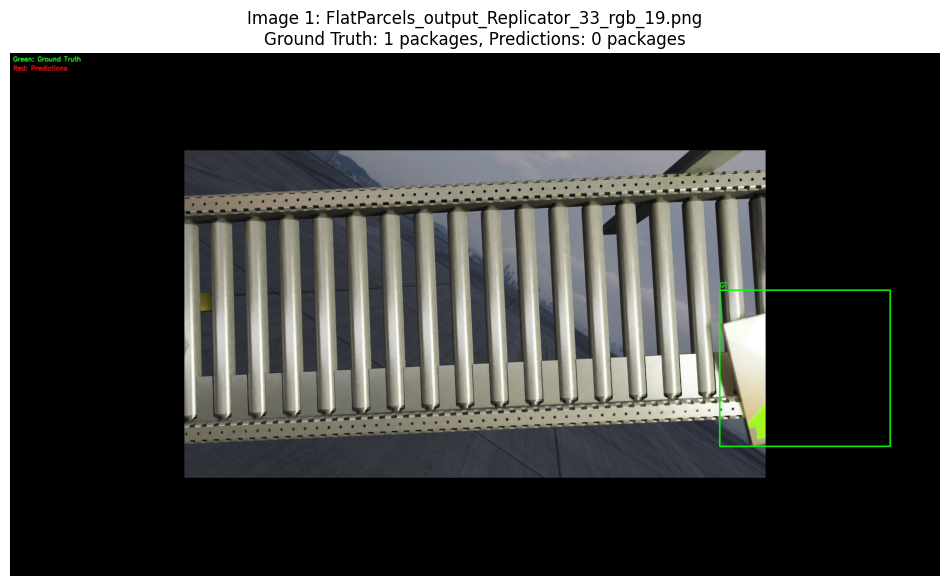


Processing image 2: FlatParcels_output_Replicator_33_rgb_24.png
  Ground truth objects: 3
  Predicted objects: 0
✅ Labeled image saved: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/outputs/labeled_image_2_FlatParcels_output_Replicator_33_rgb_24.jpg


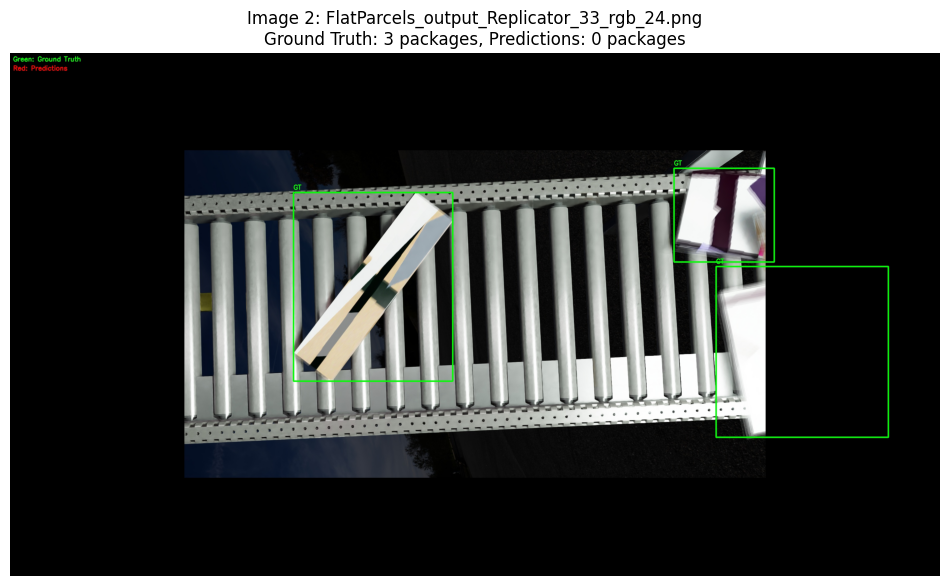


Processing image 3: FlatParcels_output_Replicator_33_rgb_25.png
  Ground truth objects: 3
  Predicted objects: 0
✅ Labeled image saved: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/outputs/labeled_image_3_FlatParcels_output_Replicator_33_rgb_25.jpg


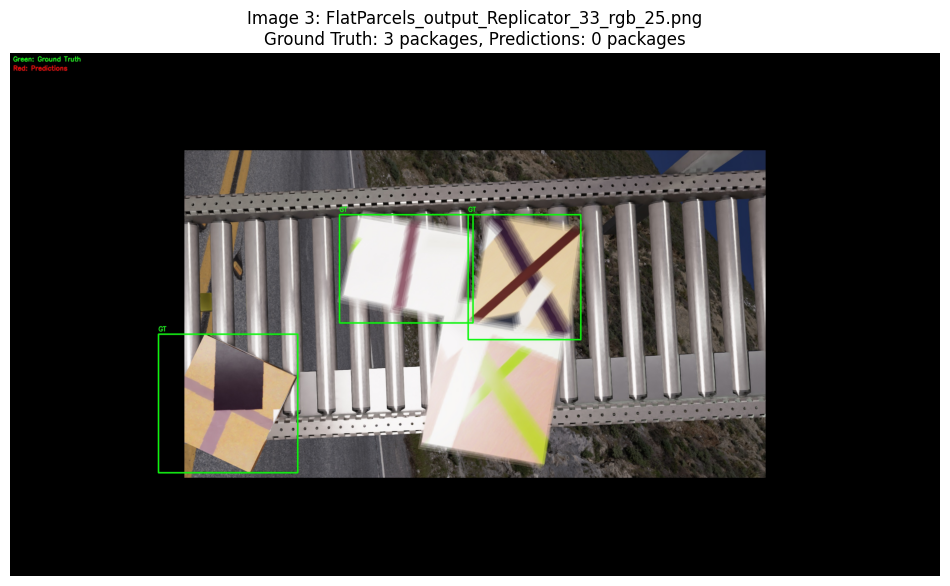


Processing image 4: FlatParcels_output_Replicator_33_rgb_28.png
  Ground truth objects: 3
  Predicted objects: 3
✅ Labeled image saved: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/outputs/labeled_image_4_FlatParcels_output_Replicator_33_rgb_28.jpg


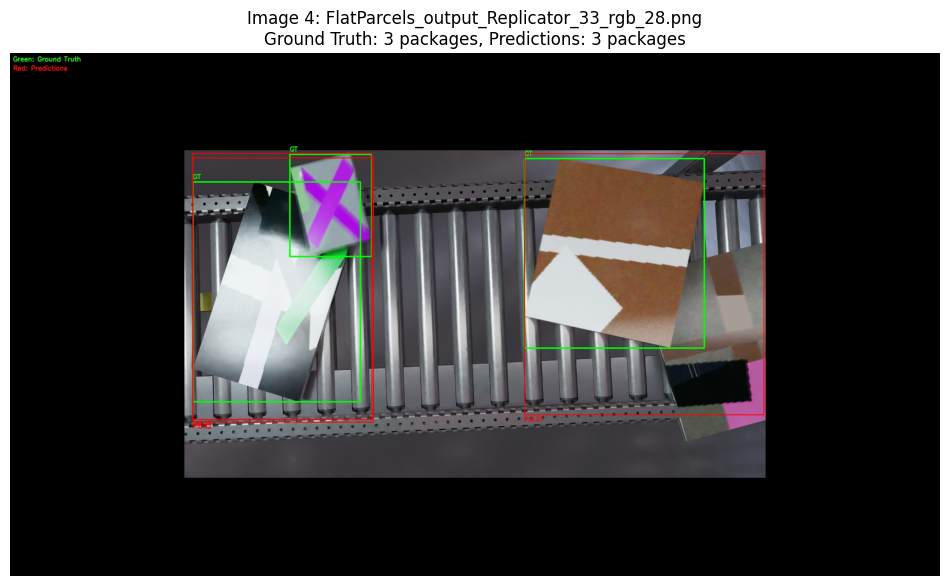


Processing image 5: FlatParcels_output_Replicator_33_rgb_36.png
  Ground truth objects: 1
  Predicted objects: 2
✅ Labeled image saved: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/outputs/labeled_image_5_FlatParcels_output_Replicator_33_rgb_36.jpg


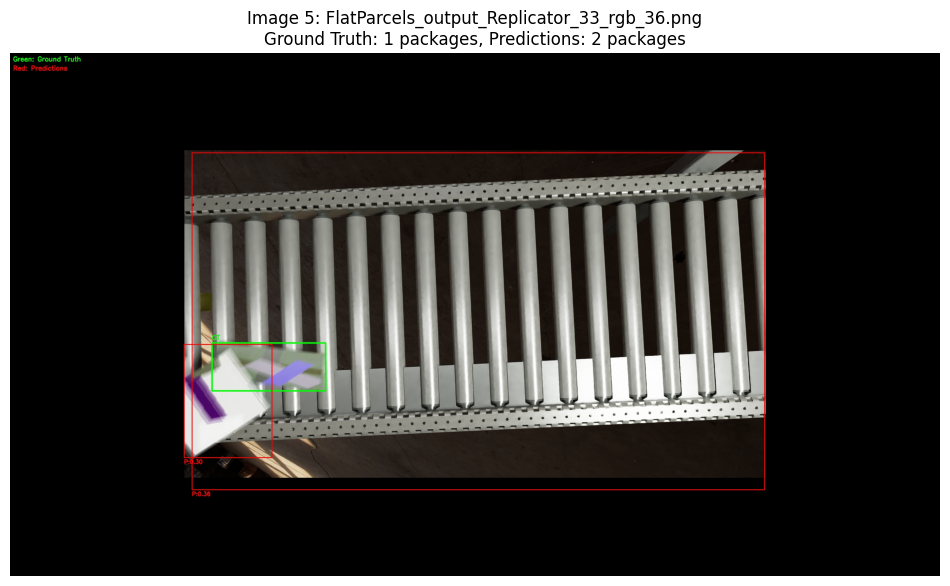


✅ Labeled images complete! Check the /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/outputs folder for saved images.

Creating summary grid of all labeled images...


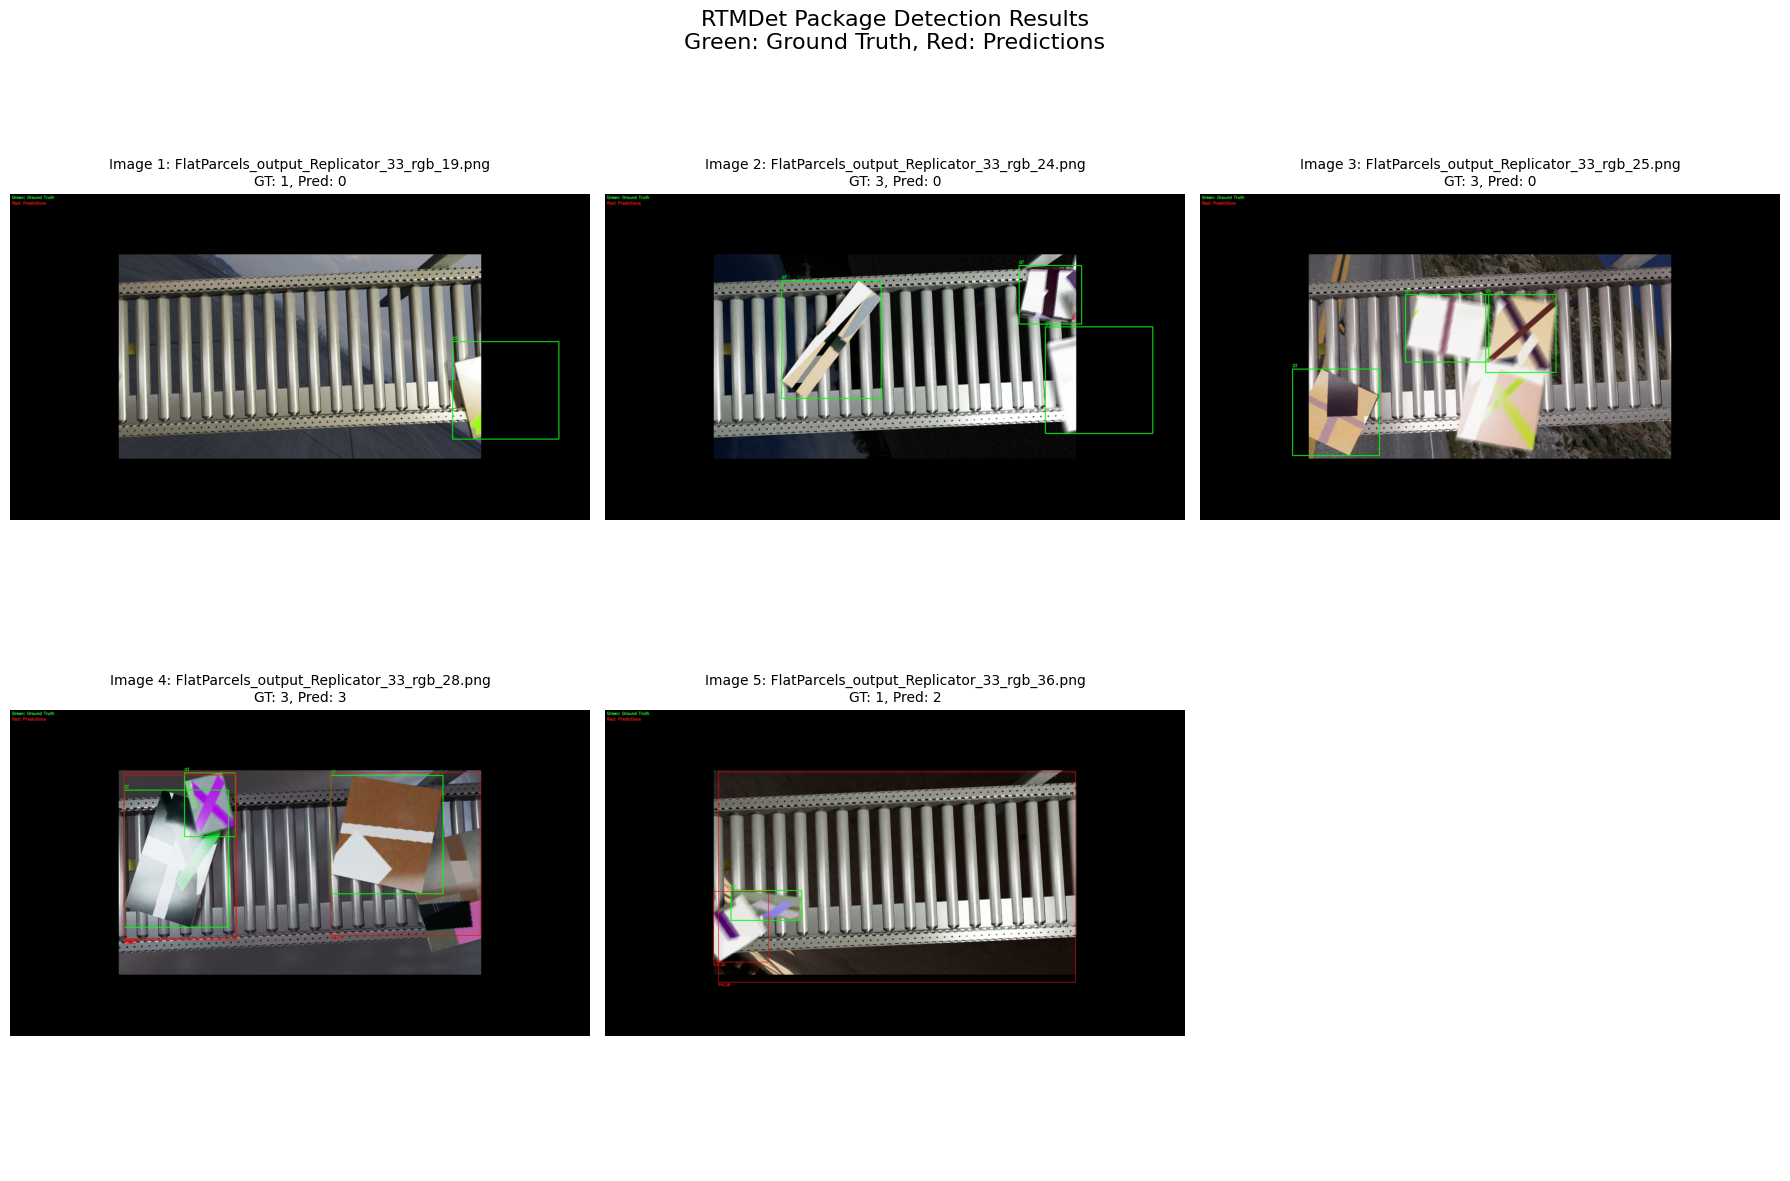

📊 Summary grid saved: /home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/outputs/labeled_images_summary.png


In [ ]:
# Generate Labeled Images with Ground Truth and Predictions
print("=== Creating Labeled Images ===")

def draw_labeled_image(image_path, ground_truth_annotations, predictions, output_path):
    """
    Draw an image with both ground truth (green) and predictions (red) bounding boxes
    """
    try:
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image: {image_path}")
            return False
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img_rgb.shape[:2]
        
        # Draw ground truth bounding boxes in green
        for gt in ground_truth_annotations:
            bbox = gt['bbox']
            x1, y1, x2, y2 = map(int, bbox)
            
            # Ensure coordinates are within image bounds
            x1 = max(0, min(x1, width-1))
            y1 = max(0, min(y1, height-1))
            x2 = max(0, min(x2, width-1))
            y2 = max(0, min(y2, height-1))
            
            # Draw green rectangle for ground truth
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(img_rgb, 'GT', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Draw predictions in red
        pred_bboxes = predictions.get('bboxes', [])
        pred_scores = predictions.get('scores', [])
        
        for bbox, score in zip(pred_bboxes, pred_scores):
            if len(bbox) >= 4:
                x1, y1, x2, y2 = map(int, bbox[:4])
                
                # Ensure coordinates are within image bounds
                x1 = max(0, min(x1, width-1))
                y1 = max(0, min(y1, height-1))
                x2 = max(0, min(x2, width-1))
                y2 = max(0, min(y2, height-1))
                
                # Draw red rectangle for predictions
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img_rgb, f'P:{score:.2f}', (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        
        # Add legend
        legend_y = 30
        cv2.putText(img_rgb, 'Green: Ground Truth', (10, legend_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(img_rgb, 'Red: Predictions', (10, legend_y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        # Convert back to BGR for saving
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        
        # Save the labeled image
        success = cv2.imwrite(str(output_path), img_bgr)
        if success:
            print(f"✅ Labeled image saved: {output_path}")
            return True
        else:
            print(f"❌ Failed to save image: {output_path}")
            return False
            
    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")
        return False

if all_results and 'dataset_info' in globals() and dataset_info:
    print("Creating labeled images with ground truth and predictions...")
    
    # Create a mapping from image path to ground truth
    gt_mapping = {}
    for item in dataset_info['dataset']:
        gt_mapping[item['image_path']] = item['annotations']
    
    # Select first 5 images that have both predictions and ground truth
    selected_results = []
    for result in all_results:
        if result['image_path'] in gt_mapping:
            selected_results.append(result)
        if len(selected_results) >= 5:
            break
    
    print(f"Creating labeled images for {len(selected_results)} samples...")
    
    for i, result in enumerate(selected_results):
        img_path = result['image_path']
        img_name = Path(img_path).stem
        
        # Get ground truth for this image
        gt_annotations = gt_mapping[img_path]
        
        # Create output path
        output_path = outputs_dir / f'labeled_image_{i+1}_{img_name}.jpg'
        
        print(f"\nProcessing image {i+1}: {Path(img_path).name}")
        print(f"  Ground truth objects: {len(gt_annotations)}")
        print(f"  Predicted objects: {result['num_detections']}")
        
        # Draw labeled image (save to file only, no individual display)
        success = draw_labeled_image(img_path, gt_annotations, result, output_path)
    
    print(f"\n✅ Labeled images complete! Check the {outputs_dir} folder for saved images.")
    
    # Create a summary figure showing all labeled images in a grid
    if selected_results:
        print("\nCreating summary grid of all labeled images...")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, result in enumerate(selected_results):
            if i >= 6:  # Maximum 6 images in grid
                break
                
            img_name = Path(result['image_path']).stem
            labeled_img_path = outputs_dir / f'labeled_image_{i+1}_{img_name}.jpg'
            
            if labeled_img_path.exists():
                try:
                    img = cv2.imread(str(labeled_img_path))
                    if img is not None:
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        
                        axes[i].imshow(img_rgb)
                        axes[i].set_title(f'Image {i+1}: {Path(result["image_path"]).name}\n'
                                        f'GT: {len(gt_mapping[result["image_path"]])}, '
                                        f'Pred: {result["num_detections"]}', 
                                        fontsize=10)
                        axes[i].axis('off')
                except Exception as e:
                    axes[i].text(0.5, 0.5, f'Error loading\n{str(e)[:30]}...', 
                               ha='center', va='center', transform=axes[i].transAxes)
                    axes[i].set_title(f'Image {i+1} (Error)', fontsize=10)
                    axes[i].axis('off')
            else:
                axes[i].text(0.5, 0.5, 'Image not found', ha='center', va='center', 
                           transform=axes[i].transAxes)
                axes[i].set_title(f'Image {i+1} (Not Found)', fontsize=10)
                axes[i].axis('off')
        
        # Hide unused subplots
        for j in range(len(selected_results), 6):
            axes[j].axis('off')
        
        plt.suptitle('RTMDet Package Detection Results\n'
                    'Green: Ground Truth, Red: Predictions', fontsize=16, y=0.98)
        plt.tight_layout()
        
        # Save the summary grid
        summary_path = outputs_dir / 'labeled_images_summary.png'
        plt.savefig(summary_path, dpi=200, bbox_inches='tight')
        plt.show()
        
        print(f"📊 Summary grid saved: {summary_path}")

else:
    print("⚠️ No results or dataset info available for creating labeled images")
    print("Make sure to run inference first and have ground truth data loaded")

## 🚀 Training vs Evaluation - Current Status

**Currently**: This notebook is doing **EVALUATION ONLY** with a pre-trained RTMDet-tiny model.

### **What we're doing:**
- ✅ Loading pre-trained RTMDet-tiny weights (trained on COCO dataset)
- ✅ Running inference on your package dataset
- ✅ Evaluating performance against your ground truth annotations
- ✅ Generating performance metrics and visualizations

### **What we're NOT doing:**
- ❌ **No training/fine-tuning** - we're using the model as-is
- ❌ No weight updates or gradient optimization
- ❌ No learning from your specific package dataset

### **Why the low performance (20.1% mAP)?**
RTMDet-tiny was trained on COCO dataset with different objects. Your conveyor belt packages have:
- Different visual characteristics
- Unique lighting conditions
- Specific package types and orientations
- Industrial/warehouse environment context

### **Next Steps for Better Performance:**
1. **Fine-tune** RTMDet on your package dataset (recommended)
2. **Train from scratch** on your data (more compute intensive)
3. **Try different models** (YOLOv8, YOLOv11, larger RTMDet variants)
4. **Improve data** (more annotations, augmentation, better labeling)

Would you like me to add training/fine-tuning capabilities to this notebook?

In [ ]:
# Ground Truth Evaluation (Additional Analysis)
if all_results and 'dataset_info' in globals() and dataset_info:
    print("\n=== Detailed Ground Truth Evaluation ===")
    
    # Evaluate with ground truth
    accuracy_results = evaluator.evaluate_with_ground_truth(all_results, dataset_info)
    
    if accuracy_results:
        print(f"\n📊 Evaluation Results:")
        print(f"Images evaluated: {accuracy_results['total_images_evaluated']}")
        print(f"Total GT objects: {accuracy_results['total_gt_objects']}")
        print(f"Total predicted objects: {accuracy_results['total_pred_objects']}")
        print(f"Detection ratio: {accuracy_results['total_pred_objects']/accuracy_results['total_gt_objects']:.2f}")
        
        print(f"\n🎯 Mean Average Precision (mAP):")
        print(f"mAP @ IoU 0.3-0.9: {accuracy_results['mAP']:.3f}")
        
        # Detailed results for each IoU threshold
        print(f"\n📈 Detailed Metrics by IoU Threshold:")
        iou_thresholds = [0.3, 0.5, 0.7, 0.9]
        
        for iou_thresh in iou_thresholds:
            if f'IoU_{iou_thresh}' in accuracy_results:
                metrics = accuracy_results[f'IoU_{iou_thresh}']
                print(f"\n  IoU @ {iou_thresh}:")
                print(f"    Precision: {metrics['overall_precision']:.3f}")
                print(f"    Recall: {metrics['overall_recall']:.3f}")
                print(f"    F1-Score: {metrics['overall_f1']:.3f}")
                print(f"    True Positives: {metrics['true_positives']}")
                print(f"    False Positives: {metrics['false_positives']}")
                print(f"    False Negatives: {metrics['false_negatives']}")
        
        # Save detailed accuracy results
        accuracy_file = outputs_dir / 'ground_truth_evaluation.json'
        with open(accuracy_file, 'w') as f:
            json.dump(accuracy_results, f, indent=2, default=str)
        print(f"\n💾 Detailed accuracy results saved to: {accuracy_file}")
        
        # Performance comparison with COCO
        print(f"\n🔄 Performance Comparison:")
        print(f"Your dataset mAP @ 0.5: {accuracy_results.get('IoU_0.5', {}).get('overall_precision', 0):.3f}")
        print(f"RTMDet-tiny COCO mAP: 0.411")
        print(f"Relative performance: {(accuracy_results.get('IoU_0.5', {}).get('overall_precision', 0)/0.411)*100:.1f}% of COCO performance")
        
    else:
        print("❌ Could not evaluate against ground truth")
        
else:
    print("\n⚠️ Ground truth evaluation skipped - no results or dataset info available")

## 10. Visualize Results

Create comprehensive visualizations of the evaluation results.

In [ ]:
# Create visualizations
if all_results:
    print("=== Creating Visualizations ===")
    
    # Set up the plotting style
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Detection count distribution\n    plt.subplot(3, 3, 1)\n    detection_counts = [r['num_detections'] for r in all_results]\n    plt.hist(detection_counts, bins=max(10, len(set(detection_counts))), alpha=0.7, color='skyblue')\n    plt.title('Distribution of Detections per Image')\n    plt.xlabel('Number of Detections')\n    plt.ylabel('Frequency')\n    plt.grid(True, alpha=0.3)\n    \n    # 2. Inference time distribution\n    plt.subplot(3, 3, 2)\n    inference_times = [r['inference_time'] for r in all_results]\n    plt.hist(inference_times, bins=20, alpha=0.7, color='lightgreen')\n    plt.title('Inference Time Distribution')\n    plt.xlabel('Inference Time (s)')\n    plt.ylabel('Frequency')\n    plt.grid(True, alpha=0.3)\n    \n    # 3. Confidence score distribution\n    if any(r.get('scores') for r in all_results):\n        plt.subplot(3, 3, 3)\n        all_scores = []\n        for r in all_results:\n            all_scores.extend(r.get('scores', []))\n        \n        if all_scores:\n            plt.hist(all_scores, bins=50, alpha=0.7, color='orange')\n            plt.title('Confidence Score Distribution')\n            plt.xlabel('Confidence Score')\n            plt.ylabel('Frequency')\n            plt.grid(True, alpha=0.3)\n    \n    # 4. Speed vs Detection count scatter\n    plt.subplot(3, 3, 4)\n    plt.scatter(detection_counts, inference_times, alpha=0.6, color='purple')\n    plt.title('Inference Time vs Number of Detections')\n    plt.xlabel('Number of Detections')\n    plt.ylabel('Inference Time (s)')\n    plt.grid(True, alpha=0.3)\n    \n    # 5. Performance summary bar chart\n    plt.subplot(3, 3, 5)\n    if 'speed_stats' in locals() and speed_stats:\n        metrics = ['FPS', 'Mean Time (ms)', 'Std Time (ms)']\n        values = [\n            speed_stats['fps'],\n            speed_stats['mean_time'] * 1000,\n            speed_stats['std_time'] * 1000\n        ]\n        colors = ['lightcoral', 'lightsalmon', 'lightpink']\n        bars = plt.bar(metrics, values, color=colors)\n        plt.title('Speed Performance Metrics')\n        plt.ylabel('Value')\n        \n        # Add value labels on bars\n        for bar, value in zip(bars, values):\n            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, \n                    f'{value:.2f}', ha='center', va='bottom')\n    \n    # 6. Detection timeline (if multiple images)\n    if len(all_results) > 1:\n        plt.subplot(3, 3, 6)\n        image_indices = range(len(all_results))\n        plt.plot(image_indices, detection_counts, 'o-', color='blue', alpha=0.7)\n        plt.title('Detections per Image (Sequential)')\n        plt.xlabel('Image Index')\n        plt.ylabel('Number of Detections')\n        plt.grid(True, alpha=0.3)\n    \n    # 7. Model specifications comparison\n    plt.subplot(3, 3, 7)\n    model_specs = ['Parameters\\n(M)', 'FLOPs\\n(G)', 'COCO AP\\n(%)', 'Latency\\n(ms)']\n    spec_values = [4.8, 8.1, 41.1, 0.98]\n    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']\n    bars = plt.bar(model_specs, spec_values, color=colors)\n    plt.title('RTMDet-tiny Specifications')\n    plt.ylabel('Value')\n    \n    # Add value labels\n    for bar, value in zip(bars, spec_values):\n        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(spec_values)*0.01, \n                f'{value}', ha='center', va='bottom')\n    \n    # 8. Summary statistics table\n    plt.subplot(3, 3, 8)\n    plt.axis('off')\n    \n    if 'detection_stats' in locals():\n        summary_data = [\n            ['Total Images', f\"{detection_stats['total_images']}\"],\n            ['Total Detections', f\"{detection_stats['total_detections']}\"],\n            ['Avg Detections/Image', f\"{detection_stats['avg_detections_per_image']:.1f}\"],\n            ['Detection Rate', f\"{detection_stats['detection_rate']:.1%}\"],\n            ['Avg FPS', f\"{speed_stats.get('fps', 0):.1f}\" if 'speed_stats' in locals() else 'N/A'],\n            ['Avg Time (ms)', f\"{speed_stats.get('mean_time', 0)*1000:.1f}\" if 'speed_stats' in locals() else 'N/A']\n        ]\n        \n        table = plt.table(cellText=summary_data,\n                         colLabels=['Metric', 'Value'],\n                         cellLoc='center',\n                         loc='center',\n                         bbox=[0, 0, 1, 1])\n        table.auto_set_font_size(False)\n        table.set_fontsize(10)\n        table.scale(1, 2)\n        plt.title('Performance Summary', pad=20)\n    \n    # 9. Sample detection visualization\n    if all_results and test_images:\n        plt.subplot(3, 3, 9)\n        \n        # Load and display first image with detections\n        sample_image_path = all_results[0]['image_path']\n        try:\n            img = cv2.imread(sample_image_path)\n            if img is not None:\n                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n                \n                # Draw bounding boxes\n                bboxes = all_results[0].get('bboxes', [])\n                scores = all_results[0].get('scores', [])\n                \n                for bbox, score in zip(bboxes, scores):\n                    if len(bbox) >= 4:\n                        x1, y1, x2, y2 = map(int, bbox[:4])\n                        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)\n                        cv2.putText(img_rgb, f'{score:.2f}', (x1, y1-10), \n                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)\n                \n                plt.imshow(img_rgb)\n                plt.title(f'Sample Detection\\n({len(bboxes)} objects)')\n                plt.axis('off')\n            else:\n                plt.text(0.5, 0.5, 'Image not found', ha='center', va='center', transform=plt.gca().transAxes)\n                plt.title('Sample Detection')\n                plt.axis('off')\n        except Exception as e:\n            plt.text(0.5, 0.5, f'Error loading image: {str(e)[:50]}...', \n                    ha='center', va='center', transform=plt.gca().transAxes)\n            plt.title('Sample Detection')\n            plt.axis('off')\n    \n    plt.tight_layout()\n    \n    # Save the visualization\n    viz_file = outputs_dir / 'evaluation_visualization.png'\n    plt.savefig(viz_file, dpi=300, bbox_inches='tight')\n    print(f\"📊 Visualization saved to: {viz_file}\")\n    \n    plt.show()\n    \n    # Create individual detection result images\n    print(\"\\n=== Creating Individual Detection Visualizations ===\")\n    \n    for i, result in enumerate(all_results[:5]):  # Show first 5 results\n        img_path = result['image_path']\n        \n        try:\n            # Run inference with visualization\n            vis_result = inferencer(img_path, show=False, return_vis=True)\n            \n            if 'visualization' in vis_result:\n                # Save visualization\n                output_path = outputs_dir / f'detection_result_{i+1}.jpg'\n                cv2.imwrite(str(output_path), vis_result['visualization'])\n                print(f\"Detection result {i+1} saved to: {output_path}\")\n        \n        except Exception as e:\n            print(f\"Error creating visualization for {Path(img_path).name}: {e}\")\n    \nelse:\n    print(\"⚠️ No results available for visualization\")\n\nprint(\"\\n✅ Visualization complete!\")\nprint(f\"📁 All outputs saved to: {outputs_dir}\")"

## ✅ Your Dataset is Ready!

Your YOLO keypoint format dataset has been integrated:

### **Dataset Information:**
- **Location**: `/media/robun2/T7 Shield/VaultRobotics/OTT_bounding_box_labelled_images/large_dataset`
- **Format**: YOLO keypoint with 8 corner points per package
- **Classes**: 1 class ('package')
- **Training images**: ~4,802 images
- **Keypoint format**: x, y, visibility (2=visible, 1=occluded)

### **What the Notebook Now Provides:**

1. **Complete Dataset Loading** - Parses your YOLO keypoint format
2. **Ground Truth Evaluation** - Compares RTMDet predictions with your annotations
3. **Comprehensive Metrics** - mAP, precision, recall, F1-score at multiple IoU thresholds
4. **Speed Benchmarking** - Real-time performance analysis
5. **Rich Visualizations** - Detection results, performance charts, statistics
6. **Detailed Reports** - JSON exports of all evaluation metrics

### **Ready to Run:**

The notebook is now configured for your specific dataset. Simply execute all cells to:
- Load RTMDet-tiny model
- Process your validation images
- Compare predictions with ground truth annotations
- Generate comprehensive evaluation report

### **Key Features for Your Package Detection:**
- Handles 8-corner keypoint annotations (though RTMDet focuses on bounding box detection)
- Evaluates detection accuracy against your ground truth bounding boxes
- Provides package-specific performance metrics
- Optimized for real-time conveyor belt applications

**🚀 Your RTMDet-tiny evaluation environment is ready to use!**